In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

- avgRhm: 습도
- ddMes: 적설량
- sumSsHr: 일조시간
- avgPs: 해면기압
- avgTca: 전운량
- minTa: 최저기온
- maxTa: 최고기온
- avgWs: 풍속
- sumRn: 강수량
- avgTa: 평균기온
- avgTd: 평균 이슬점온도


In [ ]:
weather = pd.read_csv('weather.csv', names=['date', 'avgTa', 'minTa', 'minTaHrmt', 'maxTa', 'maxTaHrmt', 'mi10MaxRn', 'mi10MaxRnHrmt', 'hr1MaxRn', 'hr1MaxRnHrmt', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxInsWsWd', 'maxInsWsHrmt', 'maxWs', 'maxWsWd', 'maxWsHrmt', 'avgWs', 'hr24SumRws', 'maxWd', 'avgTd', 'minRhm', 'minRhmHrmt', 'avgRhm', 'avgPv', 'avgPa', 'maxPs', 'maxPsHrmt', 'minPs', 'minPsHrmt', 'avgPs', 'ssDur', 'sumSsHr', 'hr1MaxIcsrHrmt', 'hr1MaxIcsr', 'sumGsr', 'ddMefs', 'ddMefsHrmt', 'ddMes', 'ddMesHrmt', 'sumDpthFhsc', 'avgTca', 'avgLmac', 'avgTs', 'minTg', 'avgCm5Te', 'avgCm10Te', 'avgCm20Te', 'avgCm30Te', 'avgM05Te', 'avgM10Te', 'avgM15Te', 'avgM30Te', 'avgM50Te', 'sumLrgEv', 'sumSmlEv', 'n99Rn', 'iscs', 'sumFogDur'])
# weather = weather.drop(['iscs'], axis = 1)
weather.set_index('date', inplace=True)
weather = weather[['avgRhm', 'ddMes', 'sumSsHr', 'avgPs', 'avgTca', 'avgTd', 'minTa', 'maxTa', 'avgWs', 'sumRn', 'avgTa']]
weather.head(1)

,avgRhm,ddMes,sumSsHr,avgPs,avgTca,avgTd,minTa,maxTa,avgWs,sumRn,avgTa
date,,,,,,,,,,,
2020-10-05,57.3,0.0,10.5,1018.2,2.3,4.8,8.5,18.4,2.5,0.0,13.3


In [ ]:
confirmed = pd.read_csv('covid-confirmed-in-seoul.csv', names=['date', 'confirmed'])
confirmed.set_index('date', inplace=True)
confirmed.head(1)

,confirmed
date,
2021-10-05,521


In [ ]:
df = pd.merge(weather, confirmed, how='inner', on='date')
train, test= train_test_split(df, random_state=42)
train.shape, test.shape

((275, 12), (92, 12))

In [ ]:
target = 'confirmed' 
features = df.columns.drop('confirmed')

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test)

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 10,
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [ ]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 31347.2
[200]	valid_0's l2: 27725.6
[300]	valid_0's l2: 26771
[400]	valid_0's l2: 26554.9
[500]	valid_0's l2: 26491.7
[600]	valid_0's l2: 25947.4
[700]	valid_0's l2: 25973.2
Early stopping, best iteration is:
[620]	valid_0's l2: 25752


In [ ]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  25752.024720112582
R2 score:  0.5061622922193673


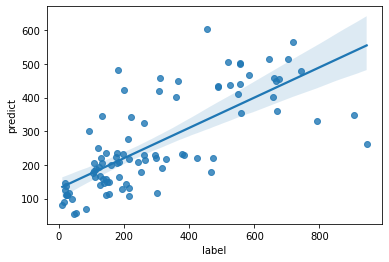

In [ ]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result);

In [ ]:
# pip install shap

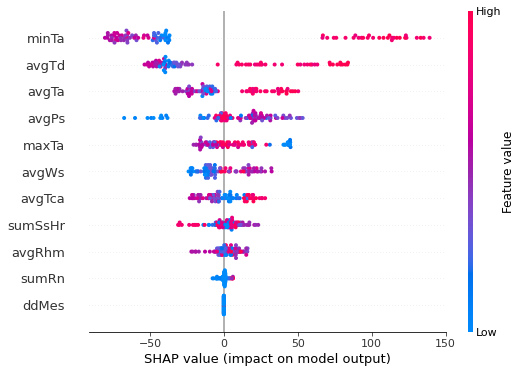

In [ ]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.externals import joblib
 
# save model
joblib.dump(model, 'lgb.pkl')
 
# load model
load_model = joblib.load('lgb.pkl')
load_model